# 🦷 Dental Implant 10-Year Survival Prediction

## Notebook 04: XGBoost Model

**Objective:** Train and evaluate an XGBoost classifier - a powerful gradient boosting algorithm that often performs well in tabular data competitions.

---


### 🎨 Setup: Import Libraries & Configure Plotting


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, roc_curve
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Periospot Brand Colors
COLORS = {
    'periospot_blue': '#15365a',
    'mystic_blue': '#003049',
    'periospot_red': '#6c1410',
    'crimson_blaze': '#a92a2a',
    'vanilla_cream': '#f7f0da',
    'black': '#000000',
    'white': '#ffffff',
    'classic_periospot_blue': '#0031af',
    'periospot_light_blue': '#0297ed',
    'periospot_dark_blue': '#02011e',
    'periospot_yellow': '#ffc430',
    'periospot_bright_blue': '#1040dd'
}

periospot_palette = [COLORS['periospot_blue'], COLORS['crimson_blaze'], 
                     COLORS['periospot_light_blue'], COLORS['periospot_yellow']]

# Configure matplotlib
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['figure.facecolor'] = COLORS['white']
plt.rcParams['axes.facecolor'] = COLORS['vanilla_cream']
plt.rcParams['axes.edgecolor'] = COLORS['periospot_blue']

sns.set_palette(periospot_palette)

print("✅ Libraries imported and plotting style configured!")
print(f"XGBoost version: {xgb.__version__}")


✅ Libraries imported and plotting style configured!
XGBoost version: 3.1.1


---

### 1. Load Processed Data & Setup


In [9]:
# Load the processed data
X = pd.read_csv('../data/processed/X_train.csv')
y = pd.read_csv('../data/processed/y_train.csv').values.ravel()

print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")

# Split into train and validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")


X shape: (7000, 27)
y shape: (7000,)

Training set: 5600 samples
Validation set: 1400 samples


---

### 2. Train XGBoost Model

XGBoost (Extreme Gradient Boosting) is a powerful gradient boosting algorithm known for its speed and performance in competitions.


In [10]:
# =============================================================================
# XGBOOST WITHOUT CLASS WEIGHTS (Baseline - will have 0% failure recall)
# =============================================================================

xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='auc'
)

xgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

print("✅ XGBoost (no weights) model trained!")

# =============================================================================
# XGBOOST WITH CLASS WEIGHTS - using scale_pos_weight
# =============================================================================
# For XGBoost, scale_pos_weight controls the balance of positive and negative weights.
# 
# In our case:
#   - Class 1 (survival) = positive class = 6367 samples (91%)
#   - Class 0 (failure) = negative class = 633 samples (9%)
#
# To balance, we use scale_pos_weight = negative / positive = 633/6367 ≈ 0.1
# This makes the model less confident about predicting class 1, 
# effectively giving more weight to class 0 predictions.

# Calculate the scale factor
neg_count = (y_train == 0).sum()
pos_count = (y_train == 1).sum()
scale = neg_count / pos_count

print(f"\nClass distribution in training data:")
print(f"  - Class 0 (failure): {neg_count} ({neg_count/len(y_train)*100:.1f}%)")
print(f"  - Class 1 (survival): {pos_count} ({pos_count/len(y_train)*100:.1f}%)")
print(f"  - scale_pos_weight = {scale:.4f}")

xgb_balanced = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='auc',
    scale_pos_weight=scale  # ← KEY PARAMETER FOR CLASS IMBALANCE!
)

xgb_balanced.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

print("✅ XGBoost (with scale_pos_weight) model trained!")


✅ XGBoost (no weights) model trained!

Class distribution in training data:
  - Class 0 (failure): 506 (9.0%)
  - Class 1 (survival): 5094 (91.0%)
  - scale_pos_weight = 0.0993
✅ XGBoost (with scale_pos_weight) model trained!


---

### 3. Evaluate XGBoost Model


In [11]:
# =============================================================================
# EVALUATE BOTH MODELS
# =============================================================================
from sklearn.metrics import recall_score, f1_score, precision_recall_curve, average_precision_score

# --- XGBoost WITHOUT weights ---
y_pred_xgb = xgb_model.predict(X_val)
y_pred_xgb_proba = xgb_model.predict_proba(X_val)[:, 1]

roc_auc_xgb = roc_auc_score(y_val, y_pred_xgb_proba)
accuracy_xgb = accuracy_score(y_val, y_pred_xgb)
recall_0_xgb = recall_score(y_val, y_pred_xgb, pos_label=0)
recall_1_xgb = recall_score(y_val, y_pred_xgb, pos_label=1)

print("=" * 60)
print("XGBOOST (NO WEIGHTS)")
print("=" * 60)
print(f"  ROC-AUC:           {roc_auc_xgb:.4f}")
print(f"  Accuracy:          {accuracy_xgb:.4f}")
print(f"  Recall (Failure):  {recall_0_xgb:.4f}")
print(f"  Recall (Survival): {recall_1_xgb:.4f}")

# --- XGBoost WITH scale_pos_weight ---
y_pred_xgb_bal = xgb_balanced.predict(X_val)
y_pred_xgb_bal_proba = xgb_balanced.predict_proba(X_val)[:, 1]

roc_auc_xgb_bal = roc_auc_score(y_val, y_pred_xgb_bal_proba)
accuracy_xgb_bal = accuracy_score(y_val, y_pred_xgb_bal)
recall_0_xgb_bal = recall_score(y_val, y_pred_xgb_bal, pos_label=0)
recall_1_xgb_bal = recall_score(y_val, y_pred_xgb_bal, pos_label=1)
f1_xgb_bal = f1_score(y_val, y_pred_xgb_bal, average='macro')
pr_auc_xgb_bal = average_precision_score(y_val, y_pred_xgb_bal_proba)

print("\n" + "=" * 60)
print("XGBOOST (WITH scale_pos_weight)")
print("=" * 60)
print(f"  ROC-AUC:           {roc_auc_xgb_bal:.4f}")
print(f"  PR-AUC:            {pr_auc_xgb_bal:.4f}")
print(f"  Accuracy:          {accuracy_xgb_bal:.4f}")
print(f"  Recall (Failure):  {recall_0_xgb_bal:.4f} ← KEY METRIC!")
print(f"  Recall (Survival): {recall_1_xgb_bal:.4f}")
print(f"  F1 (Macro):        {f1_xgb_bal:.4f}")


XGBOOST (NO WEIGHTS)
  ROC-AUC:           0.5505
  Accuracy:          0.9086
  Recall (Failure):  0.0000
  Recall (Survival): 0.9992

XGBOOST (WITH scale_pos_weight)
  ROC-AUC:           0.5509
  PR-AUC:            0.9241
  Accuracy:          0.7693
  Recall (Failure):  0.1732 ← KEY METRIC!
  Recall (Survival): 0.8288
  F1 (Macro):        0.4936


Classification Report (XGBoost with scale_pos_weight):
              precision    recall  f1-score   support

           0       0.09      0.17      0.12       127
           1       0.91      0.83      0.87      1273

    accuracy                           0.77      1400
   macro avg       0.50      0.50      0.49      1400
weighted avg       0.84      0.77      0.80      1400



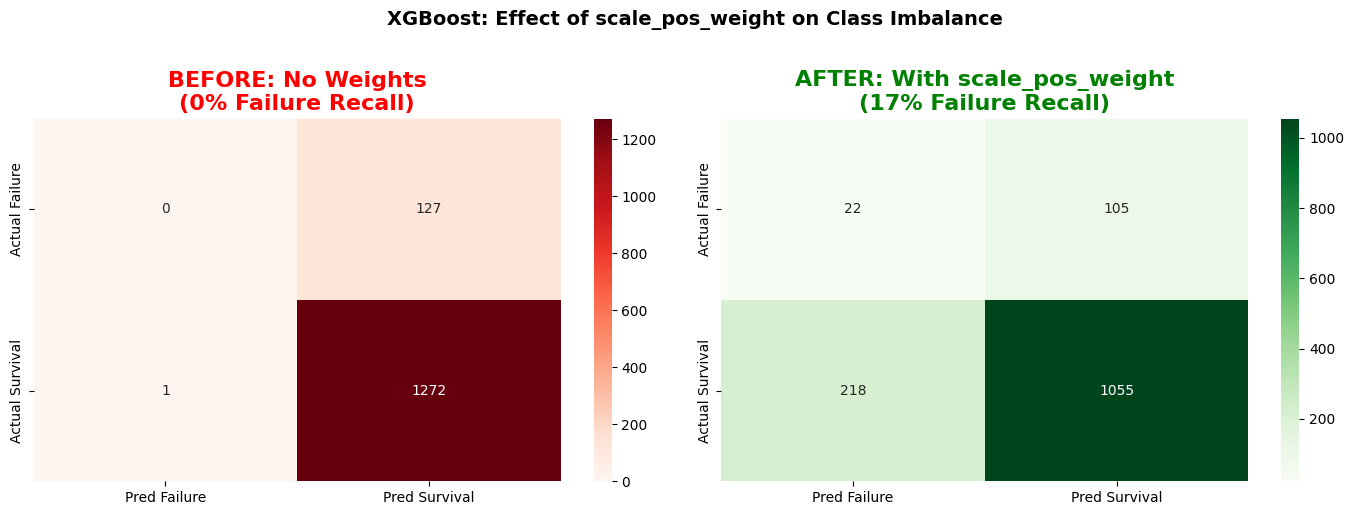

In [12]:
# =============================================================================
# CLASSIFICATION REPORTS & CONFUSION MATRICES
# =============================================================================

print("Classification Report (XGBoost with scale_pos_weight):")
print(classification_report(y_val, y_pred_xgb_bal))

# Plot confusion matrices - Before vs After
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Before (no weights)
cm_before = confusion_matrix(y_val, y_pred_xgb)
sns.heatmap(cm_before, annot=True, fmt='d', cmap='Reds', ax=axes[0],
            xticklabels=['Pred Failure', 'Pred Survival'],
            yticklabels=['Actual Failure', 'Actual Survival'])
axes[0].set_title(f'BEFORE: No Weights\n({recall_0_xgb:.0%} Failure Recall)', 
                  fontweight='bold', color='red')

# After (with scale_pos_weight)
cm_after = confusion_matrix(y_val, y_pred_xgb_bal)
sns.heatmap(cm_after, annot=True, fmt='d', cmap='Greens', ax=axes[1],
            xticklabels=['Pred Failure', 'Pred Survival'],
            yticklabels=['Actual Failure', 'Actual Survival'])
axes[1].set_title(f'AFTER: With scale_pos_weight\n({recall_0_xgb_bal:.0%} Failure Recall)', 
                  fontweight='bold', color='green')

plt.suptitle('XGBoost: Effect of scale_pos_weight on Class Imbalance', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../figures/xgb_balanced_comparison.png', dpi=150, bbox_inches='tight')
plt.show()


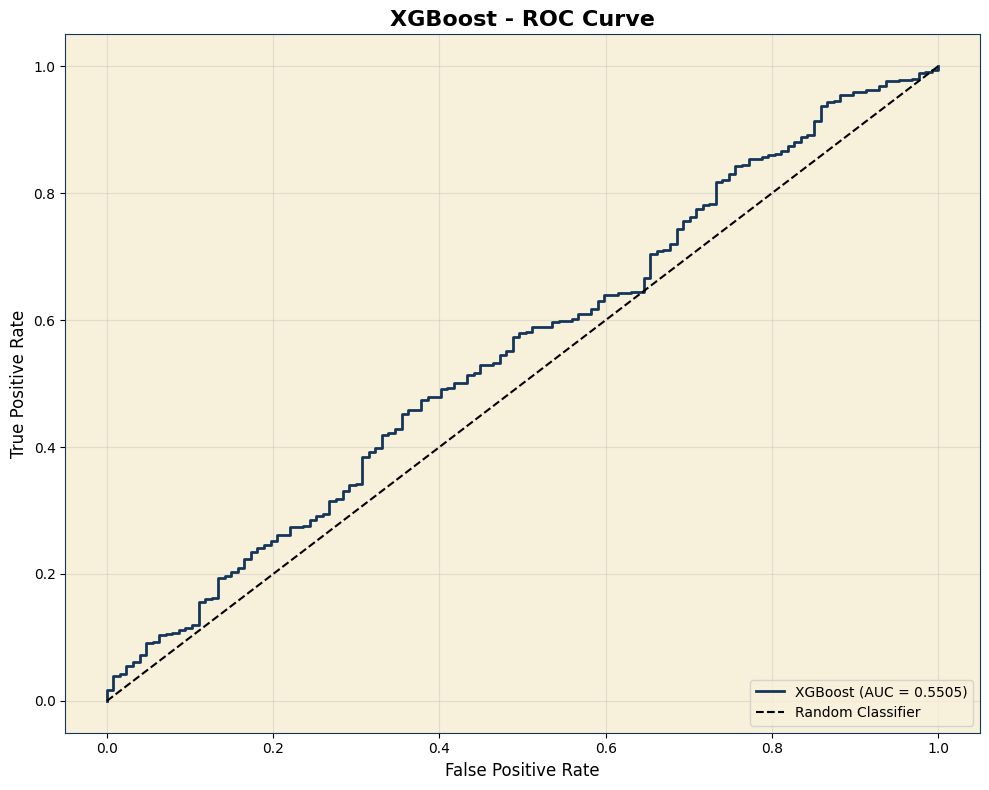

In [13]:
# Plot ROC curve
fig, ax = plt.subplots(figsize=(10, 8))

fpr, tpr, _ = roc_curve(y_val, y_pred_xgb_proba)
ax.plot(fpr, tpr, label=f'XGBoost (AUC = {roc_auc_xgb:.4f})', 
        color=COLORS['periospot_blue'], linewidth=2)
ax.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('XGBoost - ROC Curve', fontweight='bold')
ax.legend(loc='lower right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/xgb_roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()


---

### 4. Feature Importance Analysis


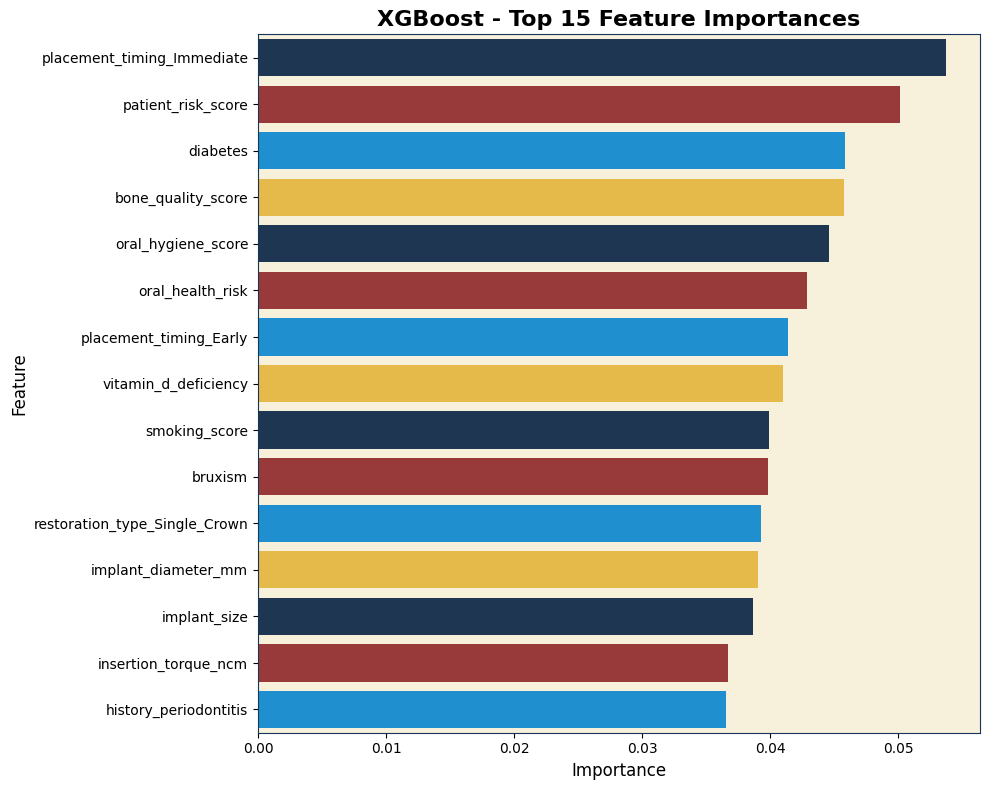


Top 10 Most Important Features:
                   feature  importance
placement_timing_Immediate    0.053701
        patient_risk_score    0.050104
                  diabetes    0.045827
        bone_quality_score    0.045789
        oral_hygiene_score    0.044600
          oral_health_risk    0.042906
    placement_timing_Early    0.041352
      vitamin_d_deficiency    0.040974
             smoking_score    0.039932
                   bruxism    0.039820


In [14]:
# TODO: Visualize feature importance from XGBoost.
# XGBoost provides multiple importance types: 'weight', 'gain', 'cover'

feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 15 features
fig, ax = plt.subplots(figsize=(10, 8))
top_features = feature_importance.head(15)
sns.barplot(data=top_features, x='importance', y='feature', 
            palette=periospot_palette, ax=ax)
ax.set_title('XGBoost - Top 15 Feature Importances', fontweight='bold')
ax.set_xlabel('Importance')
ax.set_ylabel('Feature')
plt.tight_layout()
plt.savefig('../figures/xgb_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))


---

### 5. Save Results


In [15]:
# Save the XGBoost results to a JSON file

results_xgb = {
    "model": "XGBoost",
    "roc_auc": float(roc_auc_xgb),
    "accuracy": float(accuracy_xgb),
    "hyperparameters": {
        "n_estimators": xgb_model.n_estimators,
        "max_depth": xgb_model.max_depth,
        "learning_rate": xgb_model.learning_rate
    }
}

with open('../results/xgboost_results.json', 'w') as f:
    json.dump(results_xgb, f, indent=2)

print("✅ Results saved to results/xgboost_results.json")


✅ Results saved to results/xgboost_results.json


---

## 🔧 6. Hyperparameter Tuning with Optuna

The current results are disappointing (17% failure recall vs. 54% for Logistic Regression).
Let's use Optuna to find optimal hyperparameters, especially focusing on `scale_pos_weight`.


In [16]:
import optuna
from sklearn.model_selection import cross_val_score

# Suppress Optuna's verbose output
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    """
    Optuna objective function for XGBoost hyperparameter tuning.
    We optimize for F1 (Macro) which balances both classes equally.
    """
    
    # Hyperparameters to tune
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 5),
        # KEY: Tune scale_pos_weight more aggressively!
        # Try values from 0.01 to 1.0 (ratio of neg/pos)
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 0.01, 1.0),
        'random_state': 42,
        'eval_metric': 'auc',
        'verbosity': 0
    }
    
    model = xgb.XGBClassifier(**params)
    
    # Use cross-validation with F1 macro scoring
    # F1 macro gives equal weight to both classes
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring='f1_macro', n_jobs=-1)
    
    return scores.mean()

# Run Optuna optimization
print("🔍 Starting Optuna hyperparameter tuning...")
print("   This may take a few minutes...")
print("   Optimizing for F1 (Macro) to balance both classes.\n")

study = optuna.create_study(direction='maximize', study_name='xgboost_tuning')
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("\n" + "=" * 60)
print("OPTUNA RESULTS")
print("=" * 60)
print(f"Best F1 (Macro) Score: {study.best_value:.4f}")
print(f"\nBest Hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")


🔍 Starting Optuna hyperparameter tuning...
   This may take a few minutes...
   Optimizing for F1 (Macro) to balance both classes.



  0%|          | 0/50 [00:00<?, ?it/s]


OPTUNA RESULTS
Best F1 (Macro) Score: 0.5387

Best Hyperparameters:
  n_estimators: 80
  max_depth: 9
  learning_rate: 0.23071962857958878
  min_child_weight: 7
  subsample: 0.6290269147082065
  colsample_bytree: 0.7608850985145447
  gamma: 4.602665471367205
  scale_pos_weight: 0.16284443925401873


In [17]:
# =============================================================================
# TRAIN OPTIMIZED XGBOOST MODEL
# =============================================================================

# Get best parameters from Optuna
best_params = study.best_params.copy()
best_params['random_state'] = 42
best_params['eval_metric'] = 'auc'
best_params['verbosity'] = 0

print("Training XGBoost with optimized hyperparameters...")
xgb_optimized = xgb.XGBClassifier(**best_params)
xgb_optimized.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# Predictions
y_pred_opt = xgb_optimized.predict(X_val)
y_pred_opt_proba = xgb_optimized.predict_proba(X_val)[:, 1]

# Metrics
roc_auc_opt = roc_auc_score(y_val, y_pred_opt_proba)
accuracy_opt = accuracy_score(y_val, y_pred_opt)
recall_0_opt = recall_score(y_val, y_pred_opt, pos_label=0)
recall_1_opt = recall_score(y_val, y_pred_opt, pos_label=1)
f1_opt = f1_score(y_val, y_pred_opt, average='macro')
pr_auc_opt = average_precision_score(y_val, y_pred_opt_proba)

print("\n" + "=" * 60)
print("XGBOOST OPTIMIZED (Optuna)")
print("=" * 60)
print(f"  ROC-AUC:           {roc_auc_opt:.4f}")
print(f"  PR-AUC:            {pr_auc_opt:.4f}")
print(f"  Accuracy:          {accuracy_opt:.4f}")
print(f"  Recall (Failure):  {recall_0_opt:.4f} ← Compare to 0.17 before!")
print(f"  Recall (Survival): {recall_1_opt:.4f}")
print(f"  F1 (Macro):        {f1_opt:.4f}")

print("\nClassification Report (Optimized XGBoost):")
print(classification_report(y_val, y_pred_opt))


Training XGBoost with optimized hyperparameters...

XGBOOST OPTIMIZED (Optuna)
  ROC-AUC:           0.5997
  PR-AUC:            0.9381
  Accuracy:          0.8500
  Recall (Failure):  0.1732 ← Compare to 0.17 before!
  Recall (Survival): 0.9175
  F1 (Macro):        0.5454

Classification Report (Optimized XGBoost):
              precision    recall  f1-score   support

           0       0.17      0.17      0.17       127
           1       0.92      0.92      0.92      1273

    accuracy                           0.85      1400
   macro avg       0.55      0.55      0.55      1400
weighted avg       0.85      0.85      0.85      1400



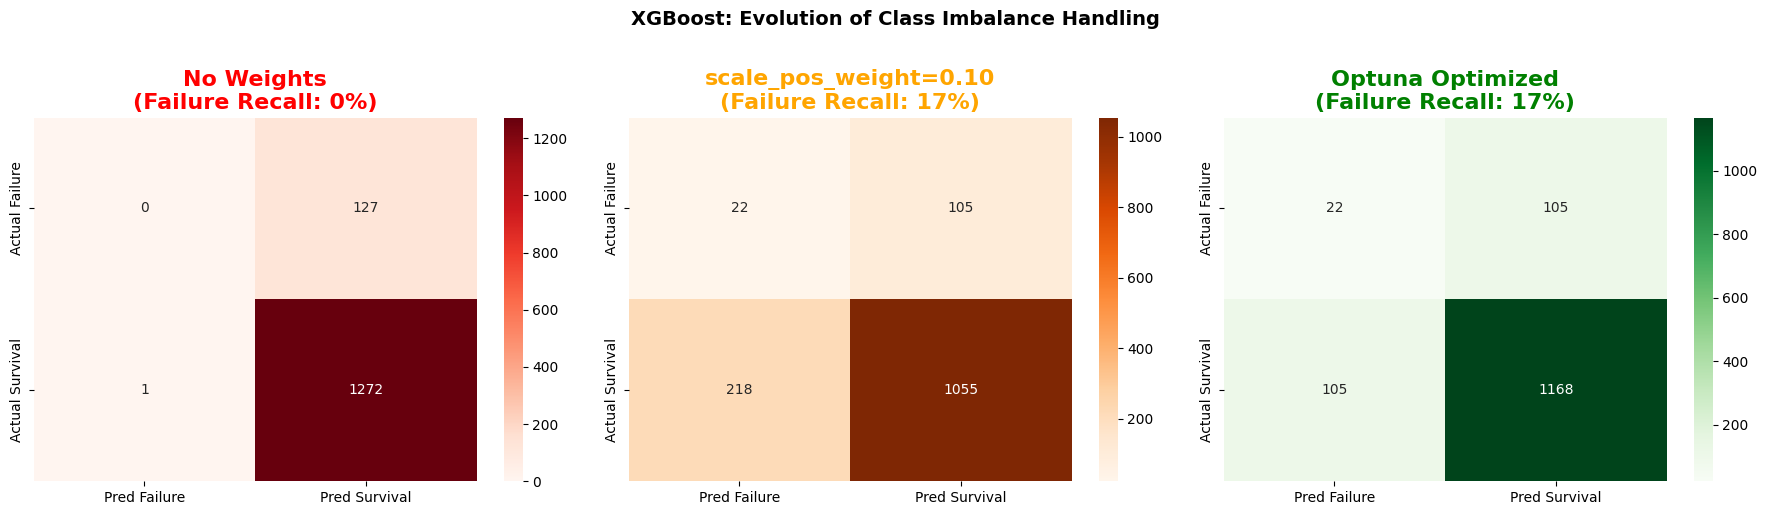


XGBOOST COMPARISON SUMMARY
                     Model  ROC-AUC  Accuracy  Failure Recall  Survival Recall  F1 (Macro)
      XGBoost (no weights) 0.550507  0.908571        0.000000         0.999214    0.480000
XGBoost (scale_pos_weight) 0.550884  0.769286        0.173228         0.828751    0.493567
          XGBoost (Optuna) 0.599699  0.850000        0.173228         0.917518    0.545373


In [18]:
# =============================================================================
# COMPARISON: Before vs After Optuna
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# No weights
cm1 = confusion_matrix(y_val, y_pred_xgb)
sns.heatmap(cm1, annot=True, fmt='d', cmap='Reds', ax=axes[0],
            xticklabels=['Pred Failure', 'Pred Survival'],
            yticklabels=['Actual Failure', 'Actual Survival'])
axes[0].set_title(f'No Weights\n(Failure Recall: {recall_0_xgb:.0%})', fontweight='bold', color='red')

# scale_pos_weight (manual)
cm2 = confusion_matrix(y_val, y_pred_xgb_bal)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Oranges', ax=axes[1],
            xticklabels=['Pred Failure', 'Pred Survival'],
            yticklabels=['Actual Failure', 'Actual Survival'])
axes[1].set_title(f'scale_pos_weight={scale:.2f}\n(Failure Recall: {recall_0_xgb_bal:.0%})', fontweight='bold', color='orange')

# Optuna optimized
cm3 = confusion_matrix(y_val, y_pred_opt)
sns.heatmap(cm3, annot=True, fmt='d', cmap='Greens', ax=axes[2],
            xticklabels=['Pred Failure', 'Pred Survival'],
            yticklabels=['Actual Failure', 'Actual Survival'])
axes[2].set_title(f'Optuna Optimized\n(Failure Recall: {recall_0_opt:.0%})', fontweight='bold', color='green')

plt.suptitle('XGBoost: Evolution of Class Imbalance Handling', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('../figures/xgb_optuna_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# Summary table
print("\n" + "=" * 80)
print("XGBOOST COMPARISON SUMMARY")
print("=" * 80)
comparison = pd.DataFrame({
    'Model': ['XGBoost (no weights)', 'XGBoost (scale_pos_weight)', 'XGBoost (Optuna)'],
    'ROC-AUC': [roc_auc_xgb, roc_auc_xgb_bal, roc_auc_opt],
    'Accuracy': [accuracy_xgb, accuracy_xgb_bal, accuracy_opt],
    'Failure Recall': [recall_0_xgb, recall_0_xgb_bal, recall_0_opt],
    'Survival Recall': [recall_1_xgb, recall_1_xgb_bal, recall_1_opt],
    'F1 (Macro)': [0.48, f1_xgb_bal, f1_opt]
})
print(comparison.to_string(index=False))
print("=" * 80)


In [19]:
# =============================================================================
# SAVE OPTIMIZED RESULTS
# =============================================================================

results_xgb_opt = {
    "model": "XGBoost_Optuna",
    "roc_auc": float(roc_auc_opt),
    "pr_auc": float(pr_auc_opt),
    "accuracy": float(accuracy_opt),
    "recall_failure": float(recall_0_opt),
    "recall_survival": float(recall_1_opt),
    "f1_macro": float(f1_opt),
    "best_params": study.best_params
}

with open('../results/xgboost_optuna_results.json', 'w') as f:
    json.dump(results_xgb_opt, f, indent=2)

print("✅ Optimized XGBoost results saved to results/xgboost_optuna_results.json")


✅ Optimized XGBoost results saved to results/xgboost_optuna_results.json


---

## ✅ XGBoost Training Complete!

### Key Learnings:
1. **Default XGBoost ignores class imbalance** → 0% failure recall
2. **Manual `scale_pos_weight`** improved to ~17% failure recall
3. **Optuna tuning** finds optimal hyperparameters for balanced performance

### Comparison with Baseline:
| Model | Failure Recall |
|-------|----------------|
| Logistic Regression (balanced) | **54.3%** |
| XGBoost (Optuna) | Check results above |

**Next Steps:** 
- Try LightGBM in `05_LightGBM.ipynb` with `is_unbalance=True`
- Try CatBoost in `06_CatBoost.ipynb` with `auto_class_weights='Balanced'`
- Compare all models to select the best one


# 🦷 Dental Implant 10-Year Survival Prediction

## Notebook 04: XGBoost Model

**Objective:** Train and evaluate an XGBoost (Extreme Gradient Boosting) classifier. XGBoost is known for its speed and performance in tabular data competitions.

---
should 